# Time series prediction

This project aims to use time series models to predict airline passenger traffic over time. The goal is to create a model that can accurately predict future passenger traffic, which can be used by airlines to better plan and allocate resources.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.metrics import mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import the data
data = pd.read_excel('airline-passengers.xlsx', index_col=0)
data

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


Each row represents a month.
## Exploratory data analysis (EDA)

##### Plotting the time series:

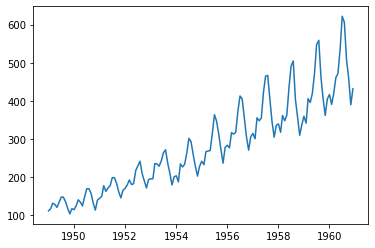

In [3]:
plt.plot(data['Passengers'])
plt.show()

##### Histogram

We will plot the distribution of values in the time series to identify outliers and skewness in the data.

array([[<AxesSubplot:title={'center':'Passengers'}>]], dtype=object)

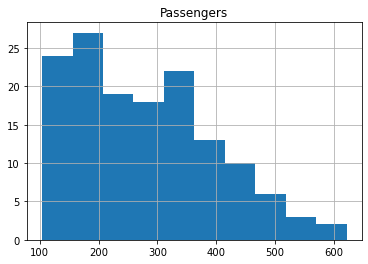

In [4]:
data.hist(bins=10)

We see positive skewness in the histogram (there are a few data points with very high values that are pulling the mean to the right). Skewness is not always a problem, but it's important to be aware of it because it can affect the choice of the model and the way the data is preprocessed.

##### Quantile-Quantile plot

We also can use a Q-Q plot to check if our dataset is normally distributed or not. It can be useful to check if the residuals of the time series model are normally distributed. If the residuals are not normally distributed, it may indicate that the chosen model is not appropriate for the data or that the data requires further preprocessing such as transforming the data.

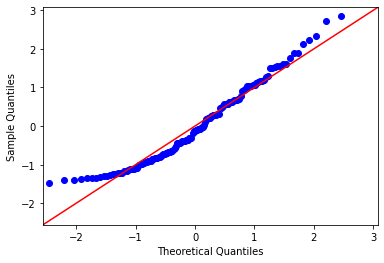

In [5]:
sm.qqplot(data.Passengers, fit=True, line="45")
plt.show()

##### Auto-correlation function plot

We will check the correlation between a point in the time series and a point at a previous time step. It can be used to identify patterns such as seasonality.

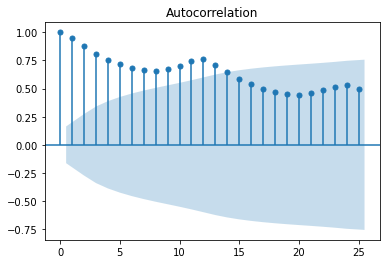

In [6]:
plot_acf(data.Passengers, lags=25)
# Show the AR as a plot
plt.show()

We see how the value of a given month (cor)relates to the value of the same month in the previous year, but also to adjacent months. Since our data is monthly, the seasonal frequency is 12.

##### Partial auto-correlation function plot

The partial autocorrelation function can be useful to help identify the appropriate order of differencing d and the order of the autoregressive term p in an ARIMA model. The number of lags that are significantly correlated with the series is an indication of the order of the autoregressive term. We use it since the autocorrelation plot can also be affected by the correlation between lags, which can make it difficult to interpret. However, the partial autocorrelation plot shows the correlation between a point in the time series and a point at a previous time step after removing the effect of the correlation between intermediate lags as we see in the plot above.

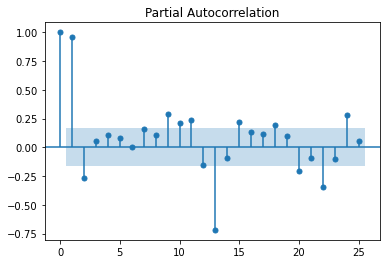

In [7]:
plot_pacf(data.Passengers, lags=25)
# Show the PAR as a plot
plt.show()

##### Seasonal decomposition of time series (STL)

We will decomposes our time series into its trend, seasonal, and residual components to get a clearer idea of the underlying structure of the time series data. By identifying these patterns, we can choose the appropriate model and parameters that can best capture the underlying structure of the data.

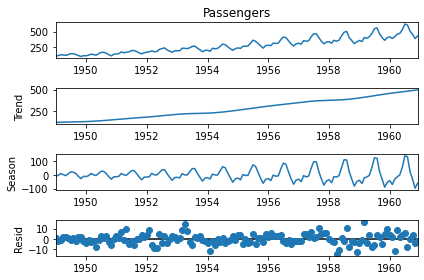

In [8]:
stl = STL(data.Passengers, period=12, seasonal=7)
res = stl.fit()
fig = res.plot()

# extract the trend component
trend = res.trend
# extract the seasonal component
seasonal = res.seasonal

We can see that the time series is not stationary since the mean is not constant (we have trend) and the variance is not constant (the seasonal effect change over time)

### Data preprocessing

##### checking missing data

In [9]:
missing_data = data.isna()
print(missing_data.sum())

Passengers    0
dtype: int64


We do not have misiing data

##### Handling outliers

Outliers can have a significant effect on the performance of a model, so they need to be either removed or transformed. We will use Z-score. It is a measure of how many standard deviations a data point is from the mean of the dataset. Data points with a Z-score greater than 3 or less than -3 will be considered outliers. However, we could also use boxplot or interquartile range (IQR) method.

In [10]:
z = np.abs(stats.zscore(data))
len(z[z>3])

0

We do not have outliers in our data

##### Stationarity

By visual inspection of the time series we see that the mean and variance are not constant over time, then our data is not stationary. We will also verify it with Augmented Dickey-Fuller (ADF) test. The null hypothesis of the test is that the data is non-stationary. If the p-value is less than the significance level (0.05), will will reject the null hypothesis and conclude that the data is stationary.

In [11]:
result = adfuller(data)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.815369
p-value: 0.991880


Indeed, our data is not stationary. We will use decomposition method to make the data stationary. We decompose the time series into its trend, seasonal and residual components. By removing the trend and seasonal components, we make the residuals stationary. We check the data again to make sure that it's stationary.

In [12]:
residuals_data = res.resid

residuals_result = adfuller(residuals_data)
print('ADF Statistic: %f' % residuals_result[0])
print('p-value: %f' % residuals_result[1])

ADF Statistic: -6.007619
p-value: 0.000000


##### Splitting the data into train and test sets

In [13]:
# splitting the residual data
train_size = int(len(residuals_data) * 0.67)
test_size = len(residuals_data) - train_size
train, test = residuals_data[0:train_size], residuals_data[train_size:len(residuals_data)]

# splitting the trend and seasonal data
trend_train, trend_test = trend[0:train_size], trend[train_size:len(trend)]
seasonal_train, seasonal_test = seasonal[0:train_size], seasonal[train_size:len(seasonal)]

Text(0.5, 0, 'Date')

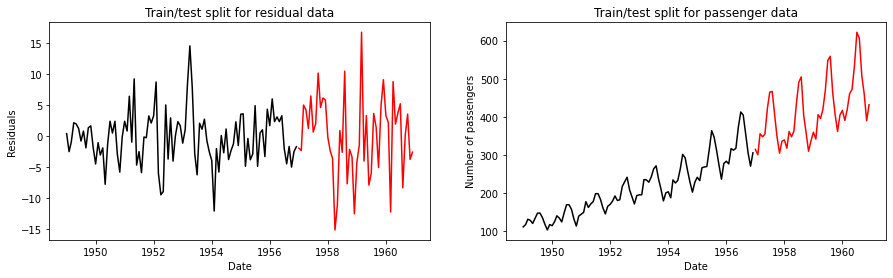

In [14]:
# Plot the train-test split
f = plt.figure(figsize=(15,4))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
x = np.linspace(0,4,1000)

ax.plot(train, color = "black")
ax.plot(test, color = "red")
ax.set_title('Train/test split for residual data')
ax.set_ylabel('Residuals')
ax.set_xlabel('Date')

ax2.plot(train+trend_train+seasonal_train, color = "black")
ax2.plot(test+trend_test+seasonal_test, color = "red")
ax2.set_title('Train/test split for passenger data')
ax2.set_ylabel('Number of passengers')
ax2.set_xlabel('Date')

## Time series models

After checking for stationarity and exmining the autocorrelation and the partial autocorrelation, we can use time series models to make predictions. We will use Akaike information criterion (AIC), which is a measure of the relative quality, to select the parameters of the models. The lowest AIC value indicates the best model.

We assume that the relationship between the past values and the current value is linear and that the error term in the model is normally distributed. We also assume that the input variables are not highly correlated with each other (no multicollinearity).

### Autoregressive (AR) model

The AR models the current value of a time series as a linear combination of its past values. AR model can capture the temporal dependencies in the data. The order of the AR model is an important parameter to be set, it represents the number of lags that are used as input variables.

The best AR model is from order: 12
RMSE:  6.42034924129901


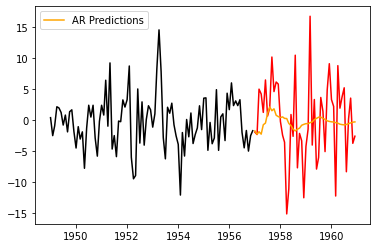

In [15]:
# List of model orders
orders = [(p,0,0) for p in range(1, 24)]

# List of model fits
model_fits = []
p_list = []

# Loop over orders and fit the model
# We will use in the ARIMA function just the AR component
for order in orders:
    ARmodel = ARIMA(train, order=order)
    model_fit = ARmodel.fit()
    model_fits.append(model_fit)
    p_list.append(order[0])

# List of AIC values
AIC_values = [model_fit.aic for model_fit in model_fits]

# The lowest AIC value
lowest_AIC = AIC_values[np.argmin(AIC_values)]
p_lowest_AIC = p_list[np.argmin(AIC_values)]

# The model with the lowest AIC value
print('The best AR model is from order:', p_lowest_AIC)

# The model with the lowest AIC value
best_model = model_fits[np.argmin(AIC_values)]

# Make predictions on the test data
AR_predictions = best_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

# Plot the best AR model
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(AR_predictions, color='orange', label = 'AR Predictions')
plt.legend()

# Print the loss value for this model
ar_rmse = np.sqrt(mean_squared_error(test.values, AR_predictions))
print("RMSE: ",ar_rmse)

### Moving average (MA) model

The MA models the current value of a time series as a linear combination of the past errors. The order of the MA model represents the number of lags that are used as input variables.

The best MA model is from order: 12
RMSE:  6.411316672311283


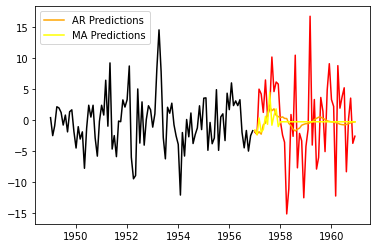

In [16]:
# List of model orders
orders = [(0,0,q) for q in range(1, 24)]

# List of model fits
model_fits = []
q_list = []

# Loop over orders and fit the model
# We will use in the ARIMA function just the MA component
for order in orders:
    MAmodel = ARIMA(train, order=order)
    model_fit = MAmodel.fit()
    model_fits.append(model_fit)
    q_list.append(order[2])

# List of AIC values
AIC_values = [model_fit.aic for model_fit in model_fits]

# The lowest AIC value
lowest_AIC = AIC_values[np.argmin(AIC_values)]
q_lowest_AIC = q_list[np.argmin(AIC_values)]

# The model with the lowest AIC value
print('The best MA model is from order:', q_lowest_AIC)

# The model with the lowest AIC value
best_model = model_fits[np.argmin(AIC_values)]

# Make predictions on the test data
MA_predictions = best_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

# Plot the best MA model
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(AR_predictions, color='orange', label = 'AR Predictions')
plt.plot(MA_predictions, color='yellow', label = 'MA Predictions')
plt.legend()

# Print the loss value for this model
ma_rmse = np.sqrt(mean_squared_error(test.values, MA_predictions))
print("RMSE: ",ma_rmse)

### Autoregressive moving average (ARMA) model

The ARMA models combines the AR and MA models and model both the short and long-term dependencies in the time series. The order of the AR component represents the short-term dependencies and the order of the MA component represents the long-term dependencies.

The best ARMA model is from order: ( 12 , 11 )
RMSE:  6.315698502297103


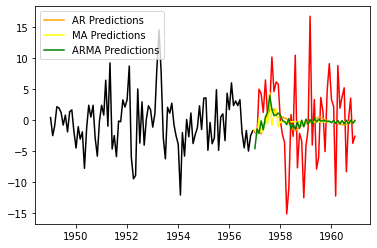

In [17]:
# List of model orders
orders = [(p, 0, q) for p in range(1, 24) for q in range(1, 24)]

# List of model fits
model_fits = []
p_list = []
q_list = []

# Loop over orders and fit the model
# We will use in the ARIMA function just the AR and MA components
for order in orders:
    ARMAmodel = ARIMA(train, order=order)
    model_fit = ARMAmodel.fit()
    model_fits.append(model_fit)
    p_list.append(order[0])
    q_list.append(order[2])
    
# List of AIC values
AIC_values = [model_fit.aic for model_fit in model_fits]

# The lowest AIC value
lowest_AIC = AIC_values[np.argmin(AIC_values)]
p_lowest_AIC = p_list[np.argmin(AIC_values)]
q_lowest_AIC = q_list[np.argmin(AIC_values)]

# The model with the lowest AIC value
print('The best ARMA model is from order: (', p_lowest_AIC,',',q_lowest_AIC,')')

# The model with the lowest AIC value
best_model = model_fits[np.argmin(AIC_values)]

# Make predictions on the test data
ARMA_predictions = best_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

# Plot the best ARMA model
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(AR_predictions, color='orange', label = 'AR Predictions')
plt.plot(MA_predictions, color='yellow', label = 'MA Predictions')
plt.plot(ARMA_predictions, color='green', label = 'ARMA Predictions')
plt.legend()

# Print the loss value for this model
arma_rmse = np.sqrt(mean_squared_error(test.values, ARMA_predictions))
print("RMSE: ",arma_rmse)

### Autoregressive integrated moving average (ARIMA) model

The ARIMA model is an extension of ARMA model that also accounts for non-stationarity in the data. The differencing step is applied to remove the trend and seasonality from the data, so that the model can better capture the temporal dependencies in the residuals. The order of differencing represents the number of times that the differencing step is applied to the data.

The best ARIMA model is from order: ( 22 , 1 , 22 )
RMSE:  6.148479400103528


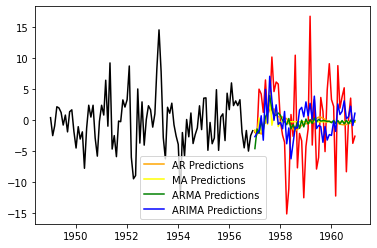

In [19]:
# List of model orders
orders = [(p, d, q) for p in range(1, 24) for d in range(1, 4) for q in range(1, 24)]

# List of model fits
model_fits = []
p_list = []
d_list = []
q_list = []

# Loop over orders and fit the model
# We will use in the ARIMA function just the AR and MA components
for order in orders:
    ARIMAmodel = ARIMA(train, order=order)
    ARIMAmodel.initialize_approximate_diffuse()
    model_fit = ARIMAmodel.fit()
    model_fits.append(model_fit)
    p_list.append(order[0])
    d_list.append(order[1])
    q_list.append(order[2])
    
# List of AIC values
AIC_values = [model_fit.aic for model_fit in model_fits]

# The lowest AIC value
lowest_AIC = AIC_values[np.argmin(AIC_values)]
p_lowest_AIC = p_list[np.argmin(AIC_values)]
d_lowest_AIC = d_list[np.argmin(AIC_values)]
q_lowest_AIC = q_list[np.argmin(AIC_values)]

# The model with the lowest AIC value
print('The best ARIMA model is from order: (', p_lowest_AIC,',',d_lowest_AIC,',',q_lowest_AIC,')')

# The model with the lowest AIC value
best_model = model_fits[np.argmin(AIC_values)]

# Make predictions on the test data
ARIMA_predictions = best_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

# Plot the best ARIMA model
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(AR_predictions, color='orange', label = 'AR Predictions')
plt.plot(MA_predictions, color='yellow', label = 'MA Predictions')
plt.plot(ARMA_predictions, color='green', label = 'ARMA Predictions')
plt.plot(ARIMA_predictions, color='blue', label = 'ARIMA Predictions')
plt.legend()

# Print the loss value for this model
arima_rmse = np.sqrt(mean_squared_error(test.values, ARIMA_predictions))
print("RMSE: ",arima_rmse)

### Seasonal autoregressive integrated moving average (SARIMA) model

The SARIMA model is an extension of the ARIMA model that also accounts for seasonality in the data. The seasonal order of the SARIMA model represents the number of lags of the seasonal component.

The best SARIMA model is from order: ( 21 , 1 , 21 ) and seasonal order of: (0,0,0, 0 )
RMSE:  6.143814993037196


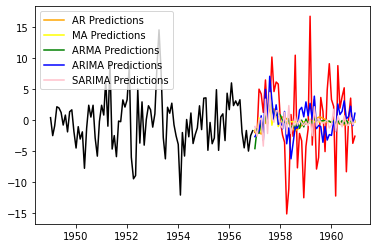

In [20]:
# List of model orders
orders = [(p, d, q) for p in range(1, 24) for d in range(1, 4) for q in range(1, 24)]
# list of seasonal orders
seasonal_orders = [(0, 0, 0, s) for s in range(2, 12)]

# List of model fits
model_fits = []
p_list = []
d_list = []
q_list = []
seasonal_p_list = []

# Loop over orders and fit the model
# We will use in the SARIMA function just the AR and MA components
for seasonal_order in seasonal_orders:
    for order in orders:
        SARIMAmodel = SARIMAX(train, order=order, seasonal_order=seasonal_order)
        model_fit = SARIMAmodel.fit()
        model_fits.append(model_fit)
        p_list.append(order[0])
        d_list.append(order[1])
        q_list.append(order[2])
        seasonal_p_list.append(seasonal_order[0])
    
# List of AIC values
AIC_values = [model_fit.aic for model_fit in model_fits]

# The lowest AIC value
lowest_AIC = AIC_values[np.argmin(AIC_values)]
p_lowest_AIC = p_list[np.argmin(AIC_values)]
d_lowest_AIC = d_list[np.argmin(AIC_values)]
q_lowest_AIC = q_list[np.argmin(AIC_values)]
seasonal_p_lowest_AIC = seasonal_p_list[np.argmin(AIC_values)]

# The model with the lowest AIC value
print('The best SARIMA model is from order: (', p_lowest_AIC,',',d_lowest_AIC,',',q_lowest_AIC,') and seasonal order of: (0,0,0,',seasonal_p_lowest_AIC,')')

# The model with the lowest AIC value
best_model = model_fits[np.argmin(AIC_values)]

# Make predictions on the test data
SARIMA_predictions = best_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

# Plot the best ARIMA model
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(AR_predictions, color='orange', label = 'AR Predictions')
plt.plot(MA_predictions, color='yellow', label = 'MA Predictions')
plt.plot(ARMA_predictions, color='green', label = 'ARMA Predictions')
plt.plot(ARIMA_predictions, color='blue', label = 'ARIMA Predictions')
plt.plot(SARIMA_predictions, color='pink', label = 'SARIMA Predictions')
plt.legend()

# Print the loss value for this model
sarima_rmse = np.sqrt(mean_squared_error(test.values, SARIMA_predictions))
print("RMSE: ",sarima_rmse)

### Model comparison

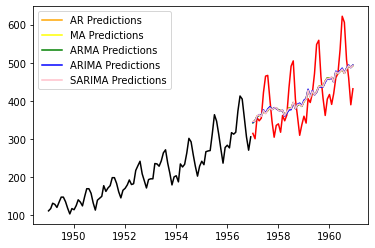

In [21]:
# Plotting the actual values against the predictions
plt.plot(train+trend_train+seasonal_train, color = "black")
plt.plot(test+trend_test+seasonal_test, color = "red")
plt.plot(test+trend_test+AR_predictions, color='orange', label = 'AR Predictions')
plt.plot(test+trend_test+MA_predictions, color='yellow', label = 'MA Predictions')
plt.plot(test+trend_test+ARMA_predictions, color='green', label = 'ARMA Predictions')
plt.plot(test+trend_test+ARIMA_predictions, color='blue', label = 'ARIMA Predictions')
plt.plot(test+trend_test+SARIMA_predictions, color='pink', label = 'SARIMA Predictions')
plt.legend()

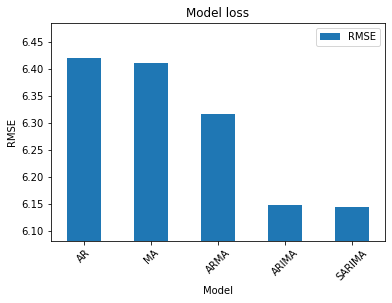

The model with the lowest RMSE is: SARIMA


In [22]:
# Plotting the loss for each model
df = pd.DataFrame([{'Model':'AR', 'RMSE':ar_rmse},{'Model':'MA', 'RMSE':ma_rmse},
                  {'Model':'ARMA', 'RMSE':arma_rmse},{'Model':'ARIMA', 'RMSE':arima_rmse},
                  {'Model':'SARIMA', 'RMSE':sarima_rmse}])

df.plot.bar(x='Model', y='RMSE')
plt.title("Model loss")
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.ylim(min(df.RMSE)*0.99, max(df.RMSE)*1.01)
plt.show()

print('The model with the lowest RMSE is:', df.Model[np.argmin(df.RMSE)])